In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # 另一個繪圖-樣式套件

import warnings
warnings.filterwarnings('ignore')

import os
from zipfile import ZipFile

# 設定 data_path
dir_data = './data/'

In [2]:
# 查看壓縮檔內的資料
f_path = os.path.join(dir_data, 'titanic.zip')
print('Path of read in data: %s' % (f_path))

myzip=ZipFile(f_path)
for i in myzip.filelist:
    print(i.filename)

Path of read in data: ./data/titanic.zip
gender_submission.csv
test.csv
train.csv


In [3]:
# 讀取壓縮檔內的資料
f=myzip.open('train.csv')
train=pd.read_csv(f)
f.close()

f=myzip.open('test.csv')
test=pd.read_csv(f)
f.close()

myzip.close()

In [4]:
# 查看資料大小
print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (891, 12)
Testing data shape:  (418, 11)


In [5]:
# 查看資料內容
def columns_type(df_data):
    dtype_df = df_data.dtypes.reset_index()
    dtype_df.columns = ['Columns', 'Type']
    dtype_df_count = dtype_df.groupby(['Type'])['Columns'].count().reset_index()
    for t, n in zip(dtype_df_count.Type, dtype_df_count.Columns):
        print('類型 : ',t,'\n')
        print('  個數 : ',n,'\n')
        print('  ',list(dtype_df[dtype_df.Type==t].Columns),'\n')
        print('-----------------------------------------------\n')
        
def object_check(df_data):    
    object_type = df_data.select_dtypes(include=["object"]).apply(pd.Series.nunique, axis = 0).reset_index() 
    object_type.columns = ["Column", "Unique Count"]
    display(object_type.head(10))        
        
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
    
columns_type(train)
object_check(train)
na_check(train)

類型 :  int64 

  個數 :  5 

   ['PassengerId', 'Survived', 'Pclass', 'SibSp', 'Parch'] 

-----------------------------------------------

類型 :  float64 

  個數 :  2 

   ['Age', 'Fare'] 

-----------------------------------------------

類型 :  object 

  個數 :  5 

   ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'] 

-----------------------------------------------



,Column,Unique Count
0,Name,891
1,Sex,2
2,Ticket,681
3,Cabin,147
4,Embarked,3


,Missing Ratio
Cabin,77.104377
Age,19.865320
Embarked,0.224467


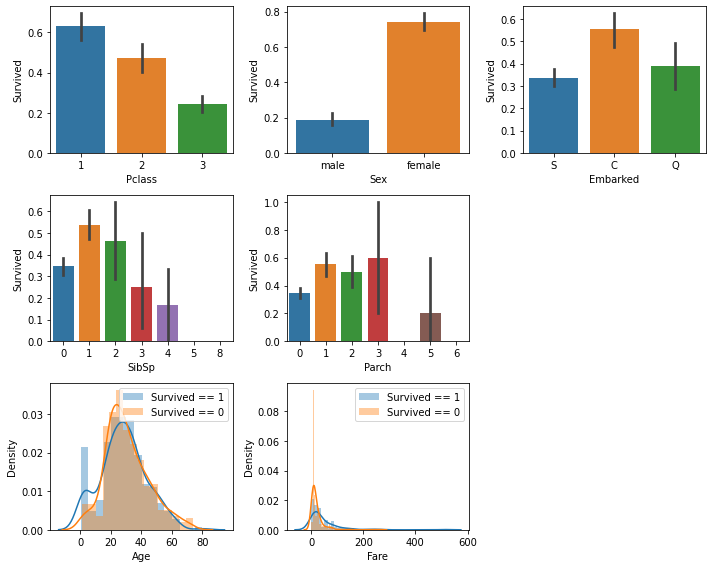

In [6]:
# 設定繪圖區域的長與寬
fig = plt.figure(figsize = (10, 8), dpi=72, 
           facecolor="white",edgecolor="green")

# 設定子圖
ax_1 = fig.add_subplot(3, 3, 1)
sns.barplot(x='Pclass',y='Survived',data=train)

ax_2 = fig.add_subplot(3, 3, 2)
sns.barplot(x='Sex',y='Survived',data=train)

ax_3 = fig.add_subplot(3, 3, 3)
sns.barplot(x='Embarked',y='Survived',data=train)

ax_4 = fig.add_subplot(3, 3, 4)
sns.barplot(x='SibSp',y='Survived',data=train)

ax_5 = fig.add_subplot(3, 3, 5)
sns.barplot(x='Parch',y='Survived',data=train)

ax_7 = fig.add_subplot(3, 3, 7)
sns.distplot(train.loc[train['Survived'] == 1, 'Age'], label = 'Survived == 1')
sns.distplot(train.loc[train['Survived'] == 0, 'Age'], label = 'Survived == 0')
ax_7.legend() # 圖例

ax_8 = fig.add_subplot(3, 3, 8)
sns.distplot(train.loc[train['Survived'] == 1, 'Fare'], label = 'Survived == 1')
sns.distplot(train.loc[train['Survived'] == 0, 'Fare'], label = 'Survived == 0')
ax_8.legend()

fig.tight_layout() # 子圖間距
plt.plot()
plt.show()

In [7]:
# 訓練資料需要 train_X, train_Y / 預測輸出需要 ids(識別每個預測值), test_X
# 在此先抽離出 train_Y 與 ids, 而先將 train_X, test_X 該有的資料合併成 df, 先作特徵工程
train_Y = train['Survived']
ids = test['PassengerId']
train_X = train.drop(['PassengerId', 'Survived'] , axis=1)
test = test.drop(['PassengerId'] , axis=1)
df = pd.concat([train_X,test], axis=0)

print('總資料維度(Train + test)',df.shape)
print('可特徵工程的欄位',list(df.columns))
df.head()

總資料維度(Train + test) (1309, 10)
可特徵工程的欄位 ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [19]:
print('樣本平均存活機率 : {:.2f}'.format(train_Y.sum()/train_Y.shape[0]))

# 整數 + 數值型變數 的基礎統計量
df.describe()

樣本平均存活機率 : 0.38


,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,29.881138,0.498854,0.385027,33.295479
std,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,80.000000,8.000000,9.000000,512.329200


In [20]:
df_etl = df.copy()
# 'Pclass' OK

# 'SibSp', 'Parch' OK
df_etl['Total_Family']=df_etl['SibSp'] + df_etl['Parch']
df_etl['Total_Family_cut3']=0
df_etl['Total_Family_cut3'][df_etl['Total_Family']!=0]=np.array(pd.cut(df_etl['Total_Family'][df_etl['Total_Family']!=0],3,labels=[1,2,3]))
# 'Age' 補中位數
df_etl['Age']=df_etl['Age'].fillna(df_etl['Age'].median())

# 'Fare'
df_etl['Fare_qcut10']=pd.qcut(df_etl['Fare'],10,labels=range(10))

# 'Name' 
import re
pattern = re.compile('\S*\.')
df_etl['Name_title'] = df_etl['Name'].apply(lambda x: pattern.findall(x)[0])

# 'Sex' OK

# 'Ticket'
Ticket_c=df_etl.groupby(['Ticket'])['Name'].count().reset_index(name='n')
df_etl['Ticket'].isin(Ticket_c[Ticket_c.n>1]['Ticket'])
df_etl['tkts']=df['Ticket'].isin(Ticket_c[Ticket_c.n>1]['Ticket']).astype('int')

# 'Cabin' 補NA
df_etl['Cabin']=df_etl['Cabin'].fillna('NA')
df_etl['Cabin_sub']=df_etl['Cabin'].apply(lambda x:x[0])

# 'Embarked' 補NA
df_etl['Embarked']=df_etl['Embarked'].fillna('NA')


# drop
df_etl=df_etl.drop(columns=['Total_Family'])
df_etl=df_etl.drop(columns=['Name'])
df_etl=df_etl.drop(columns=['Ticket'])
df_etl=df_etl.drop(columns=['Cabin'])

# GET DUMMIES
df_etl=pd.get_dummies(df_etl,drop_first = True)
df_etl.head(10)

,Pclass,Age,SibSp,Parch,Fare,Total_Family_cut3,tkts,Sex_male,Embarked_NA,Embarked_Q,...,Name_title_Rev.,Name_title_Sir.,Cabin_sub_B,Cabin_sub_C,Cabin_sub_D,Cabin_sub_E,Cabin_sub_F,Cabin_sub_G,Cabin_sub_N,Cabin_sub_T
0,3,22.0,1,0,7.2500,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,38.0,1,0,71.2833,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3,26.0,0,0,7.9250,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,35.0,1,0,53.1000,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,3,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
5,3,28.0,0,0,8.4583,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
6,1,54.0,0,0,51.8625,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
7,3,2.0,3,1,21.0750,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
8,3,27.0,0,2,11.1333,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,2,14.0,1,0,30.0708,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [21]:
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [22]:
# 資料標準化 & 切割
df_mms = MinMaxScaler().fit_transform(df_etl)
train_num = train_Y.shape[0]
train_X = df_mms[:train_num]
print('train_X',train_X.shape)

X_train, X_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.3, random_state=12)

train_X (891, 45)


In [55]:
def model_roc_curve(fpr,tpr):
    plt.figure()
    lw = 2
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate',rotation=0, labelpad=30)
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

def  CM_plot(y_test, y_pred_binarized):
    plt.figure(figsize = (10, 8), dpi=72, 
               facecolor="white",edgecolor="green")
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred_binarized)
    plt.matshow(cnf_matrix,cmap = plt.cm.Blues) # 背景颜色
    plt.colorbar() # 颜色标签

    # 内部添加图例标签
    bbox = dict(boxstyle ="round", fc ="0.8")
    for x in range(len(cnf_matrix)):
        for y in range(len(cnf_matrix)):
            plt.annotate(cnf_matrix[x,y], xy = (x,y), bbox = bbox, horizontalalignment = 'center', verticalalignment = 'center')
    plt.ylabel('True Label',rotation=0, labelpad=20)
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()
    
def KPI(y_test,y_pred_binarized):
    accuracy=metrics.accuracy_score(y_test, y_pred_binarized)
    f1 = metrics.f1_score(y_test, y_pred_binarized) # 使用 F1-Score 評估
    precision = metrics.precision_score(y_test, y_pred_binarized) # 使用 Precision 評估
    recall  = metrics.recall_score(y_test, y_pred_binarized) # 使用 recall 評估
    print('Accuracy: ',accuracy)
    print("F1-Score: ", f1) 
    print("Precision: ", precision)
    print("Recall: ", recall)

Test Data 指標

Accuracy:  0.7985074626865671
F1-Score:  0.7476635514018691
Precision:  0.7476635514018691
Recall:  0.7476635514018691


roc_auc :  0.8437336738840192


<Figure size 432x288 with 0 Axes>

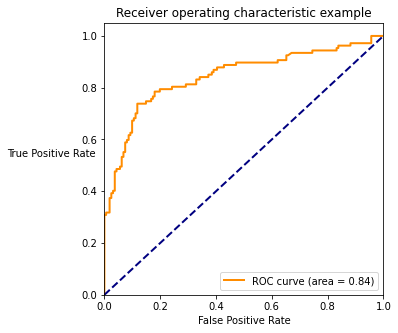

<Figure size 720x576 with 0 Axes>

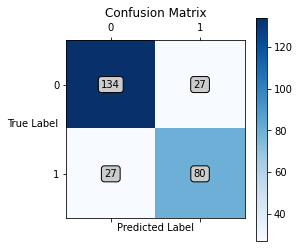

In [56]:
# 羅吉斯回歸
from sklearn.linear_model import LogisticRegression

model01 = LogisticRegression()

model01.fit(X_train,y_train)

print('Test Data 指標\n')
y_pred = model01.predict_proba(X_test,)[:,1]
threshold = 0.5
y_pred_binarized = np.where(y_pred>threshold, 1, 0) # 使用 np.where 函數, 將 y_pred > 0.5 的值變為 1，小於 0.5 的為 0
KPI(y_test,y_pred_binarized)
print('\n')
fpr,tpr,threshold = metrics.roc_curve(y_test, y_pred) ###計算真正率和假正率
roc_auc = metrics.auc(fpr,tpr) ###計算auc的值
print('roc_auc : ',roc_auc)
model_roc_curve(fpr=fpr,tpr=tpr)
CM_plot(y_test, y_pred_binarized)

Test Data 指標

Accuracy:  0.7686567164179104
F1-Score:  0.6702127659574468
Precision:  0.7777777777777778
Recall:  0.5887850467289719


roc_auc :  0.8445463516572821


<Figure size 432x288 with 0 Axes>

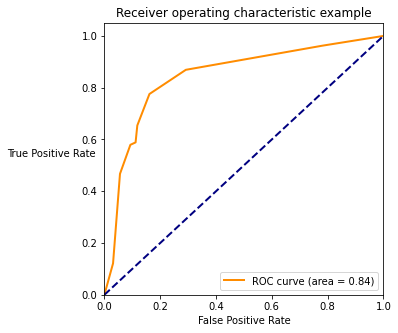

<Figure size 720x576 with 0 Axes>

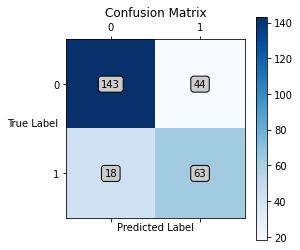

In [57]:
# 決策樹模型
from sklearn.tree import DecisionTreeClassifier

model02 = DecisionTreeClassifier(max_depth=5,random_state=12,)

model02.fit(X_train,y_train)

print('Test Data 指標\n')
y_pred = model02.predict_proba(X_test,)[:,1]
threshold = 0.5
y_pred_binarized = np.where(y_pred>threshold, 1, 0) # 使用 np.where 函數, 將 y_pred > 0.5 的值變為 1，小於 0.5 的為 0
KPI(y_test,y_pred_binarized)
print('\n')
fpr,tpr,threshold = metrics.roc_curve(y_test, y_pred) ###計算真正率和假正率
roc_auc = metrics.auc(fpr,tpr) ###計算auc的值
print('roc_auc : ',roc_auc)
model_roc_curve(fpr=fpr,tpr=tpr)
CM_plot(y_test, y_pred_binarized)

In [58]:
'''
from sklearn import tree
feature_names = df_etl.columns
target_names = y_test.astype('str').unique().tolist()
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=500)
tree.plot_tree(model02,
               feature_names = feature_names, 
               class_names=target_names,
               filled = True,fontsize=5)

plt.suptitle("Decision Tree")
plt.show()
'''

'\nfrom sklearn import tree\nfeature_names = df_etl.columns\ntarget_names = y_test.astype(\'str\').unique().tolist()\nfig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=500)\ntree.plot_tree(model02,\n               feature_names = feature_names, \n               class_names=target_names,\n               filled = True,fontsize=5)\n\nplt.suptitle("Decision Tree")\nplt.show()\n'

Test Data 指標

Accuracy:  0.8059701492537313
F1-Score:  0.7450980392156862
Precision:  0.7835051546391752
Recall:  0.7102803738317757


roc_auc :  0.8243455041504614


<Figure size 432x288 with 0 Axes>

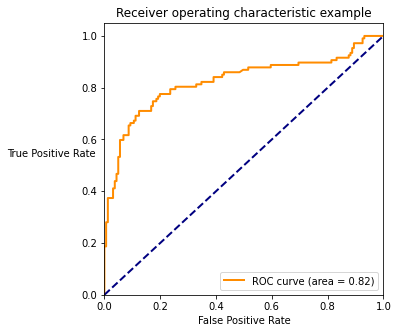

<Figure size 720x576 with 0 Axes>

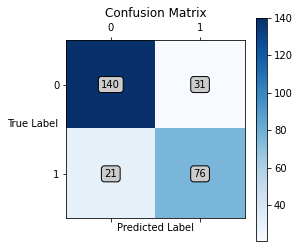

In [59]:
# 支援向量機(Support Vector Machine)
from sklearn.svm import SVC

model03 = SVC(probability = True,random_state=12,)

model03.fit(X_train, y_train)

print('Test Data 指標\n')
try:
    y_pred = model03.predict_proba(X_test,)[:,1]
    threshold = 0.5
    y_pred_binarized = np.where(y_pred>threshold, 1, 0) # 使用 np.where 函數, 將 y_pred > 0.5 的值變為 1，小於 0.5 的為 0
except:
    y_pred_binarized = model03.predict(X_test,)
KPI(y_test,y_pred_binarized)
print('\n')
fpr,tpr,threshold = metrics.roc_curve(y_test, y_pred) ###計算真正率和假正率
roc_auc = metrics.auc(fpr,tpr) ###計算auc的值
print('roc_auc : ',roc_auc)
model_roc_curve(fpr=fpr,tpr=tpr)
CM_plot(y_test, y_pred_binarized)

Test Data 指標

Accuracy:  0.8022388059701493
F1-Score:  0.7439613526570048
Precision:  0.77
Recall:  0.719626168224299


roc_auc :  0.8450397631624774


<Figure size 432x288 with 0 Axes>

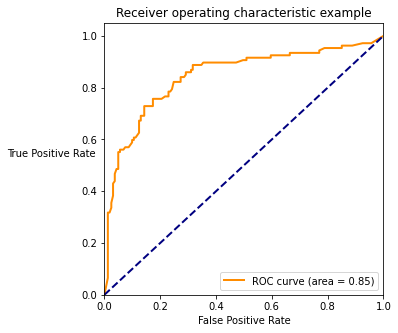

<Figure size 720x576 with 0 Axes>

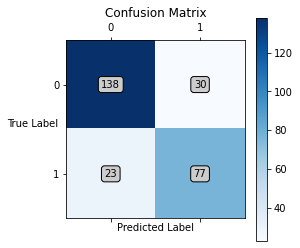

In [60]:
# 隨機森林 RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

model04 = RandomForestClassifier(n_estimators = 100,max_depth=20,random_state=12,)

model04.fit(X_train, y_train)

print('Test Data 指標\n')
try:
    y_pred = model04.predict_proba(X_test,)[:,1]
    threshold = 0.5
    y_pred_binarized = np.where(y_pred>threshold, 1, 0) # 使用 np.where 函數, 將 y_pred > 0.5 的值變為 1，小於 0.5 的為 0
except:
    y_pred_binarized = model04.predict(X_test,)
KPI(y_test,y_pred_binarized)
print('\n')
fpr,tpr,threshold = metrics.roc_curve(y_test, y_pred) ###計算真正率和假正率
roc_auc = metrics.auc(fpr,tpr) ###計算auc的值
print('roc_auc : ',roc_auc)
model_roc_curve(fpr=fpr,tpr=tpr)
CM_plot(y_test, y_pred_binarized)

Test Data 指標

Accuracy:  0.7985074626865671
F1-Score:  0.7272727272727272
Precision:  0.7912087912087912
Recall:  0.6728971962616822


roc_auc :  0.8549079932663841


<Figure size 432x288 with 0 Axes>

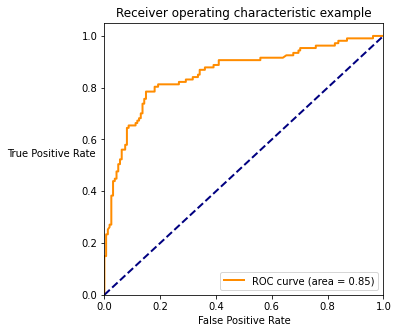

<Figure size 720x576 with 0 Axes>

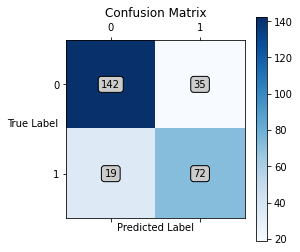

In [62]:
# GBDT (GradientBoostingClassifier)
from sklearn.ensemble import GradientBoostingClassifier

model05 = GradientBoostingClassifier(n_estimators = 100,max_depth=5,random_state=12,)

model05.fit(X_train, y_train)

print('Test Data 指標\n')
try:
    y_pred = model05.predict_proba(X_test,)[:,1]
    threshold = 0.5
    y_pred_binarized = np.where(y_pred>threshold, 1, 0) # 使用 np.where 函數, 將 y_pred > 0.5 的值變為 1，小於 0.5 的為 0
except:
    y_pred_binarized = model05.predict(X_test,)
KPI(y_test,y_pred_binarized)
print('\n')
fpr,tpr,threshold = metrics.roc_curve(y_test, y_pred) ###計算真正率和假正率
roc_auc = metrics.auc(fpr,tpr) ###計算auc的值
print('roc_auc : ',roc_auc)
model_roc_curve(fpr=fpr,tpr=tpr)
CM_plot(y_test, y_pred_binarized)